# Neural Network Analysis

**Reference**: Maleakhi Agung Wijaya  

In [199]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error as mae
import os
from pathlib2 import Path
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, models, backend as K, callbacks

In [200]:
%run Utilities.ipynb

## Load data and preprocessing

In this step, we will load all dataframes,fill missing values, and scale so that each column all features are on the same scale. Afterwards, we will generate sequential datasets using **full features, PCA features**, and only **technical indicator features**.

In [201]:
market_orders, n_markets, aggregated_datasets = load_aggregated_datasets([ 
                                                                         
                                                                          DATASET_AAPL,
                                                                          DATASET_MSFT,
                                                                          DATASET_AMZN])

## AAPL
aapl_df = aggregated_datasets["AAPL"]

## AMZN
amzn_df = aggregated_datasets["AMZN"]

## MSFT
msft_df = aggregated_datasets["MSFT"]

In [202]:
## DO NOT RUN BELOW FOR 3D CNN PRED
# Fill missing values, do some scaling (run prev cell first)
list_df = []

for df in [aapl_df, msft_df, amzn_df]:
    columns = df.columns
    for i in columns:
        df[i] = df[i].fillna(method="bfill")
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df.append(X)
    
aapl_df_full = list_df[0]
msft_df_full = list_df[1]
amzn_df_full = list_df[2]
    

In [203]:
def feature_select(df, min):
    rfecv = RFECV(estimator=LogisticRegression(), step =1, min_features_to_select=min, cv=5, scoring='accuracy')
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    selector = rfecv.fit(df.drop(columns=["MOVEMENT"]), df["MOVEMENT"])
    print("Optimal number of features: ", rfecv.n_features_)
    selected_rfe_features = pd.DataFrame({'Feature':list(X.columns), 'Ranking': selector.ranking_})
    selected_rfe_features.sort_values(by='Ranking',inplace=True)
    print(selected_rfe_features.head(rfecv.n_features_))
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(min, len(rfecv.grid_scores_) + min), rfecv.grid_scores_)
    plt.show()
    reduced_X = pd.DataFrame(selector.transform(X))
    reduced_X["MOVEMENT"] = y
    return reduced_X

Optimal number of features:  8
     Feature  Ranking
27  Feeder-F        1
23     Sugar        1
21       Oil        1
37     Mom15        1
38     Mom20        1
46       Pro        1
29       Tnx        1
43      Trix        1


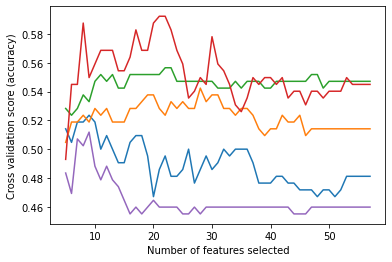

Optimal number of features:  6
      Feature  Ranking
29        Tnx        1
41     Fast_k        1
2      Volume        1
53        Cci        1
44  William_R        1
10       QCOM        1


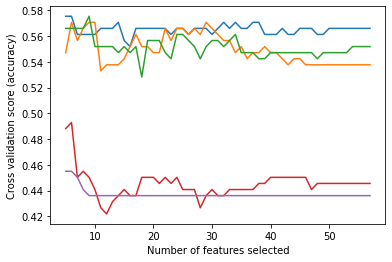

Optimal number of features:  12
     Feature  Ranking
56    Ultosc        1
17   Aud_usd        1
16   Gpb_usd        1
30       Bzf        1
13    Silver        1
12  MGC_Gold        1
22   BTC-USD        1
9       AVGO        1
10      QCOM        1
45      Rocr        1
2     Volume        1
35      Mom5        1


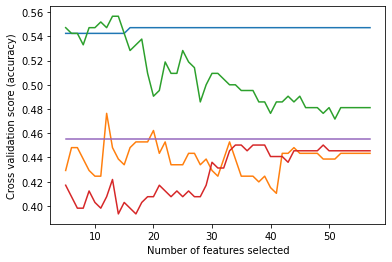

In [204]:
list_df_pca = []

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    columns = df.columns
    cur_df = df.copy()
    cur_df = feature_select(cur_df , 5)
    pca = PCA(n_components= 5)
    y = cur_df["MOVEMENT"].copy()
    X = cur_df.drop(columns=["MOVEMENT"]).copy()
    reduced_X = pd.DataFrame(pca.fit_transform(X))
    reduced_X["MOVEMENT"] = y
    list_df_pca.append(reduced_X)

aapl_df_pca = list_df_pca[0]
msft_df_pca = list_df_pca[1]
amzn_df_pca = list_df_pca[2]

In [205]:
# Technical indicator dataframe

list_df_ti = []

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    
    y = df["MOVEMENT"].copy()
    X = df[list(df.columns)[33:58]].copy()
    X["MOVEMENT"] = np.array(y)
    list_df_ti.append(X)

### Clean dataframe (ti features)
aapl_df_ti = list_df_ti[0]
msft_df_ti = list_df_ti[1]
amzn_df_ti = list_df_ti[2]


In [206]:
# Build sequential dataset
sequence_length = 60

### Sequential dataset (full features)
aapl_X_seq, aapl_y_seq = generate_sequential_data(aapl_df_full, sequence_length)
msft_X_seq, msft_y_seq = generate_sequential_data(msft_df_full, sequence_length)
amzn_X_seq, amzn_y_seq = generate_sequential_data(amzn_df_full, sequence_length)

In [207]:
### Sequential dataset (PCA features)
aapl_X_pca_seq, aapl_y_pca_seq = generate_sequential_data(aapl_df_pca, sequence_length)
msft_X_pca_seq, msft_y_pca_seq = generate_sequential_data(msft_df_pca, sequence_length)
amzn_X_pca_seq, amzn_y_pca_seq = generate_sequential_data(amzn_df_pca, sequence_length)


In [208]:
### Sequential dataset (TI features)
aapl_X_ti_seq, aapl_y_ti_seq = generate_sequential_data(aapl_df_ti, sequence_length)
msft_X_ti_seq, msft_y_ti_seq = generate_sequential_data(msft_df_ti, sequence_length)
amzn_X_ti_seq, amzn_y_ti_seq = generate_sequential_data(amzn_df_ti, sequence_length)

## 2D CNNpred

In this section, we will implement a 2D CNNpred from the paper.

### Load data

In [209]:
# Sequential flatten (full features)
aapl_X_seq_flatten = sequential_reshape(aapl_X_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_seq_flatten = sequential_reshape(msft_X_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_seq_flatten = sequential_reshape(amzn_X_seq, (len(amzn_X_seq), sequence_length, -1, 1))


In [210]:
# Sequential flatten (pca)
aapl_X_pca_seq_flatten = sequential_reshape(aapl_X_pca_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_pca_seq_flatten = sequential_reshape(msft_X_pca_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_pca_seq_flatten = sequential_reshape(amzn_X_pca_seq, (len(amzn_X_seq), sequence_length, -1, 1))


In [211]:
# Sequential flatten (technical indicator)
aapl_X_ti_seq_flatten = sequential_reshape(aapl_X_ti_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_ti_seq_flatten = sequential_reshape(msft_X_ti_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_ti_seq_flatten = sequential_reshape(amzn_X_ti_seq, (len(amzn_X_seq), sequence_length, -1, 1))

### Split into training, validation, and testing (80/10/10)

In [212]:
## Full features
aapl_X_train_full, aapl_X_test_full, aapl_y_train_full, aapl_y_test_full = train_test_split(aapl_X_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
aapl_X_train_full, aapl_X_valid_full, aapl_y_train_full, aapl_y_valid_full = train_test_split(aapl_X_train_full,
                                                                                        aapl_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
msft_X_train_full, msft_X_test_full, msft_y_train_full, msft_y_test_full = train_test_split(msft_X_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
msft_X_train_full, msft_X_valid_full, msft_y_train_full, msft_y_valid_full = train_test_split(msft_X_train_full,
                                                                                        msft_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
amzn_X_train_full, amzn_X_test_full, amzn_y_train_full, amzn_y_test_full = train_test_split(amzn_X_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_full, amzn_X_valid_full, amzn_y_train_full, amzn_y_valid_full = train_test_split(amzn_X_train_full,
                                                                                        amzn_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


In [213]:
aapl_X_train_full.shape

(809, 60, 57, 1)

In [214]:
aapl_X_valid_full.shape

(90, 60, 57, 1)

In [215]:
aapl_X_test_full.shape

(100, 60, 57, 1)

In [216]:
## pca features
aapl_X_train_pca, aapl_X_test_pca, aapl_y_train_pca, aapl_y_test_pca = train_test_split(aapl_X_pca_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
aapl_X_train_pca, aapl_X_valid_pca, aapl_y_train_pca, aapl_y_valid_pca = train_test_split(aapl_X_train_pca,
                                                                                        aapl_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_pca, msft_X_test_pca, msft_y_train_pca, msft_y_test_pca = train_test_split(msft_X_pca_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_pca, msft_X_valid_pca, msft_y_train_pca, msft_y_valid_pca = train_test_split(msft_X_train_pca,
                                                                                        msft_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_pca, amzn_X_test_pca, amzn_y_train_pca, amzn_y_test_pca = train_test_split(amzn_X_pca_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_pca, amzn_X_valid_pca, amzn_y_train_pca, amzn_y_valid_pca = train_test_split(amzn_X_train_pca,
                                                                                        amzn_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


In [217]:
## ti features
aapl_X_train_ti, aapl_X_test_ti, aapl_y_train_ti, aapl_y_test_ti = train_test_split(aapl_X_ti_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
aapl_X_train_ti, aapl_X_valid_ti, aapl_y_train_ti, aapl_y_valid_ti = train_test_split(aapl_X_train_ti,
                                                                                        aapl_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_ti, msft_X_test_ti, msft_y_train_ti, msft_y_test_ti = train_test_split(msft_X_ti_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_ti, msft_X_valid_ti, msft_y_train_ti, msft_y_valid_ti = train_test_split(msft_X_train_ti,
                                                                                        msft_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_ti, amzn_X_test_ti, amzn_y_train_ti, amzn_y_test_ti = train_test_split(amzn_X_ti_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_ti, amzn_X_valid_ti, amzn_y_train_ti, amzn_y_valid_ti = train_test_split(amzn_X_train_ti,
                                                                                        amzn_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


### Combine datasets

In [218]:
# full
# Train
X_train_full = np.concatenate(
    (aapl_X_train_full,
     msft_X_train_full,
     amzn_X_train_full,
    )
)
y_train_full = np.concatenate(
    (np.array(aapl_y_train_full),
     np.array(msft_y_train_full),
     np.array(amzn_y_train_full),
     
    )
)

# Valid
X_valid_full = np.concatenate(
    (aapl_X_valid_full,
     msft_X_valid_full,
     amzn_X_valid_full,
     )
)
y_valid_full = np.concatenate(
    (np.array(aapl_y_valid_full),
     np.array(msft_y_valid_full),
     np.array(amzn_y_valid_full),
     
    )
)

In [219]:
# pca
# Train
X_train_pca = np.concatenate(
    (aapl_X_train_pca,
     msft_X_train_pca,
     amzn_X_train_pca,
    )
)
y_train_pca = np.concatenate(
    (np.array(aapl_y_train_pca),
     np.array(msft_y_train_pca),
     np.array(amzn_y_train_pca),
     
    )
)

# Valid
X_valid_pca = np.concatenate(
    (aapl_X_valid_pca,
     msft_X_valid_pca,
     amzn_X_valid_pca,
    )
)
y_valid_pca = np.concatenate(
    (np.array(aapl_y_valid_pca),
     np.array(msft_y_valid_pca),
     np.array(amzn_y_valid_pca),
     
    )
)

In [220]:
# ti
# Train
X_train_ti = np.concatenate(
    (aapl_X_train_ti,
     msft_X_train_ti,
     amzn_X_train_ti,
     )
)
y_train_ti = np.concatenate(
    (np.array(aapl_y_train_ti),
     np.array(msft_y_train_ti),
     np.array(amzn_y_train_ti),
     
    )
)

# Valid
X_valid_ti = np.concatenate(
    (aapl_X_valid_ti,
     msft_X_valid_ti,
     amzn_X_valid_ti,
     )
)
y_valid_ti = np.concatenate(
    (np.array(aapl_y_valid_ti),
     np.array(msft_y_valid_ti),
     np.array(amzn_y_valid_ti),
     
    )
)

### Model training and evaluation

#### Full features

In [221]:
f = open("result_5_nam.txt", "a")
f.write("dsdsd")

5

In [222]:
for i in range(20):
    model_full = cnnpred_2d(60, 57, [8, 8, 8])
    epochs = 200
    batch_size=128

    ## Training
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=100, verbose=0,
        mode='auto', baseline=None, restore_best_weights=False
    )

    model_full.compile(optimizer="Adam", loss="binary_crossentropy", 
                    metrics=["acc", f1])
    model_full.fit(X_train_full, y_train_full, epochs=epochs,
                batch_size=batch_size, callbacks=[early_stopping],
                validation_data=(X_valid_full, y_valid_full))

    acc1 = -1
    acc2 = -2
    acc3 = -3
    ## aapl
    result_aapl_full = model_full.predict(aapl_X_test_full)
    result_aapl_full = (result_aapl_full > 0.5).astype(int)

    if acc1 < accuracy_score(result_aapl_full, aapl_y_test_full):
        acc1 = accuracy_score(result_aapl_full, aapl_y_test_full)
        f.write(f"aapl Accuracy: {acc1}")
        f.write(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_full, average='macro')}")
        f.write('\n')

    ## msft
    result_msft_full = model_full.predict(msft_X_test_full)
    result_msft_full = (result_msft_full > 0.5).astype(int)
    if acc2 < accuracy_score(result_msft_full, msft_y_test_full):
        acc2 = accuracy_score(result_msft_full, msft_y_test_full)
        f.write(f"msft Accuracy: {acc2}")
        f.write(f"msft F1: {f1_score(result_msft_full, msft_y_test_full, average='macro')}")
        f.write('\n')
    ## amzn
    result_amzn_full = model_full.predict(amzn_X_test_full)
    result_amzn_full = (result_amzn_full > 0.5).astype(int)
    if acc3 < accuracy_score(result_amzn_full, amzn_y_test_full):
        acc3 = accuracy_score(result_amzn_full, amzn_y_test_full)
        f.writelines(f"amzn Accuracy: {acc3}")
        f.write(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_full, average='macro')}")
        f.write('\n')

Epoch 1/200
19/19 [==============================] - 1s 21ms/step - loss: 0.6909 - acc: 0.5521 - f1: 0.3604 - val_loss: 0.6910 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 2/200
19/19 [==============================] - 0s 12ms/step - loss: 0.6878 - acc: 0.5534 - f1: 0.3559 - val_loss: 0.6933 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 3/200
19/19 [==============================] - 0s 13ms/step - loss: 0.6878 - acc: 0.5534 - f1: 0.3559 - val_loss: 0.6918 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 4/200
19/19 [==============================] - 0s 13ms/step - loss: 0.6880 - acc: 0.5534 - f1: 0.3555 - val_loss: 0.6917 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 5/200
19/19 [==============================] - 0s 11ms/step - loss: 0.6869 - acc: 0.5534 - f1: 0.3557 - val_loss: 0.6917 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 6/200
19/19 [==============================] - 0s 12ms/step - loss: 0.6866 - acc: 0.5534 - f1: 0.3558 - val_loss: 0.6914 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 7/200
19/19 [=========

In [223]:
f.close()

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        51
           1       0.53      0.61      0.57        49

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.54       100
weighted avg       0.54      0.54      0.54       100



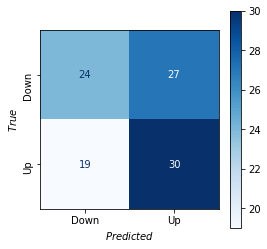

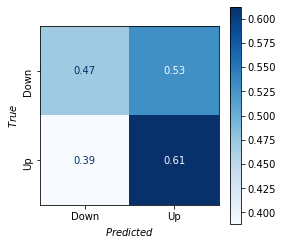

In [224]:
## AAPL
print(classification_report(result_aapl_full, aapl_y_test_full))
plot_confusion_matrix(result_aapl_full, aapl_y_test_full, labels=["Down", "Up"])

#### PCA features

In [225]:
model_pca = cnnpred_2d(60, 5, [8, 8, 8])
epochs = 200
batch_size = 128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_pca.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_pca.fit(X_train_pca, y_train_pca, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_pca, y_valid_pca))

Epoch 1/200
19/19 [==============================] - 1s 20ms/step - loss: 0.4975 - acc: 0.5385 - f1: 0.3828 - val_loss: 0.4956 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 2/200
19/19 [==============================] - 0s 11ms/step - loss: 0.4795 - acc: 0.5534 - f1: 0.3555 - val_loss: 0.4809 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 3/200
19/19 [==============================] - 0s 9ms/step - loss: 0.4526 - acc: 0.5534 - f1: 0.3558 - val_loss: 0.4708 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 4/200
19/19 [==============================] - 0s 9ms/step - loss: 0.4469 - acc: 0.5534 - f1: 0.3559 - val_loss: 0.4705 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 5/200
19/19 [==============================] - 0s 9ms/step - loss: 0.4467 - acc: 0.5534 - f1: 0.3557 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 6/200
19/19 [==============================] - 0s 10ms/step - loss: 0.4467 - acc: 0.5534 - f1: 0.3559 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 7/200
19/19 [============

In [226]:
## aapl
result_aapl_pca = model_pca.predict(aapl_X_test_pca)
result_aapl_pca = (result_aapl_pca > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_pca, aapl_y_test_pca)}")
print(f"aapl F1: {f1_score(result_aapl_pca, aapl_y_test_pca, average='macro')}")

aapl Accuracy: 0.57
aapl F1: 0.36305732484076436


In [227]:
## msft
result_msft_pca = model_pca.predict(msft_X_test_pca)
result_msft_pca = (result_msft_pca > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_pca, msft_y_test_pca)}")
print(f"msft F1: {f1_score(result_msft_pca, msft_y_test_pca, average='macro')}")

msft Accuracy: 0.55
msft F1: 0.3548387096774194


In [228]:
## amzn
result_amzn_pca = model_pca.predict(amzn_X_test_pca)
result_amzn_pca = (result_amzn_pca > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_pca, amzn_y_test_pca)}")
print(f"amzn F1: {f1_score(result_amzn_pca, amzn_y_test_pca, average='macro')}")

amzn Accuracy: 0.54
amzn F1: 0.5245969408846631


#### Technical indicator features

In [229]:
model_ti = cnnpred_2d(60, X_train_ti.shape[2], [8, 8, 8])
epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_ti.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_ti.fit(X_train_ti, y_train_ti, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_ti, y_valid_ti))

Epoch 1/200
19/19 [==============================] - 1s 19ms/step - loss: 0.4804 - acc: 0.5496 - f1: 0.3599 - val_loss: 0.4736 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 2/200
19/19 [==============================] - 0s 10ms/step - loss: 0.4475 - acc: 0.5534 - f1: 0.3560 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 3/200
19/19 [==============================] - 0s 10ms/step - loss: 0.4467 - acc: 0.5534 - f1: 0.3557 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 4/200
19/19 [==============================] - 0s 10ms/step - loss: 0.4467 - acc: 0.5534 - f1: 0.3558 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 5/200
19/19 [==============================] - 0s 10ms/step - loss: 0.4466 - acc: 0.5534 - f1: 0.3555 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 6/200
19/19 [==============================] - 0s 13ms/step - loss: 0.4466 - acc: 0.5534 - f1: 0.3558 - val_loss: 0.4704 - val_acc: 0.5296 - val_f1: 0.3424
Epoch 7/200
19/19 [=========

In [230]:
## aapl
result_aapl_ti = model_ti.predict(aapl_X_test_ti)
result_aapl_ti = (result_aapl_ti > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_ti, aapl_y_test_ti)}")
print(f"aapl F1: {f1_score(result_aapl_ti, aapl_y_test_ti, average='macro')}")

aapl Accuracy: 0.57
aapl F1: 0.36305732484076436


In [231]:
## msft
result_msft_ti = model_ti.predict(msft_X_test_ti)
result_msft_ti = (result_msft_ti > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_ti, msft_y_test_ti)}")
print(f"msft F1: {f1_score(result_msft_ti, msft_y_test_ti, average='macro')}")

msft Accuracy: 0.55
msft F1: 0.3548387096774194


In [232]:
## amzn
result_amzn_ti = model_ti.predict(amzn_X_test_ti)
result_amzn_ti = (result_amzn_ti > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_ti, amzn_y_test_ti)}")
print(f"amzn F1: {f1_score(result_amzn_ti, amzn_y_test_ti, average='macro')}")

amzn Accuracy: 0.49
amzn F1: 0.32885906040268453


## Correlation

In [233]:
model_cor = cnnpred_2d(30, aapl_X_test_cor.shape[2], [8, 8, 8])
epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_cor.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_cor.fit(X_train_cor, y_train_cor, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_cor, y_valid_cor))

NameError: name 'aapl_X_test_cor' is not defined

In [ ]:
## aapl
result_aapl_cor = model_cor.predict(aapl_X_test_cor)
result_aapl_cor = (result_aapl_ti > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_cor, aapl_y_test_cor)}")
print(f"aapl F1: {f1_score(result_aapl_ti, aapl_y_test_ti, average='macro')}")

In [ ]:
## msft
result_msft_cor = model_cor.predict(msft_X_test_cor)
result_msft_cor = (result_msft_ti > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_cor, msft_y_test_cor)}")
print(f"msft F1: {f1_score(result_msft_cor, msft_y_test_cor, average='macro')}")



In [ ]:
## amzn
result_amzn_cor = model_cor.predict(amzn_X_test_cor)
result_amzn_cor = (result_amzn_cor > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_cor, amzn_y_test_cor)}")
print(f"amzn F1: {f1_score(result_amzn_cor, amzn_y_test_cor, average='macro')}")

## Feedforward Neural Networks

### Load data

In [ ]:
# Sequential flatten (full features)
aapl_X_seq_flatten = sequential_reshape(aapl_X_seq, (len(aapl_X_seq), -1))
msft_X_seq_flatten = sequential_reshape(msft_X_seq, (len(msft_X_seq), -1))
amzn_X_seq_flatten = sequential_reshape(amzn_X_seq, (len(amzn_X_seq), -1))


In [ ]:
# Sequential flatten (pca)
aapl_X_pca_seq_flatten = sequential_reshape(aapl_X_pca_seq, (len(aapl_X_pca_seq), -1))
msft_X_pca_seq_flatten = sequential_reshape(msft_X_pca_seq, (len(msft_X_pca_seq), -1))
amzn_X_pca_seq_flatten = sequential_reshape(amzn_X_pca_seq, (len(amzn_X_pca_seq), -1))


In [ ]:
# Sequential flatten (technical indicator)
aapl_X_ti_seq_flatten = sequential_reshape(aapl_X_ti_seq, (len(aapl_X_ti_seq), -1))
msft_X_ti_seq_flatten = sequential_reshape(msft_X_ti_seq, (len(msft_X_ti_seq), -1))
amzn_X_ti_seq_flatten = sequential_reshape(amzn_X_ti_seq, (len(amzn_X_ti_seq), -1))


### Split into training/validation/test (80/10/10)

In [ ]:
## Full features
aapl_X_train_full, aapl_X_test_full, aapl_y_train_full, aapl_y_test_full = train_test_split(aapl_X_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
aapl_X_train_full, aapl_X_valid_full, aapl_y_train_full, aapl_y_valid_full = train_test_split(aapl_X_train_full,
                                                                                        aapl_y_train_full,
                                                                                        stratify=aapl_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
msft_X_train_full, msft_X_test_full, msft_y_train_full, msft_y_test_full = train_test_split(msft_X_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
msft_X_train_full, msft_X_valid_full, msft_y_train_full, msft_y_valid_full = train_test_split(msft_X_train_full,
                                                                                        msft_y_train_full,
                                                                                        stratify=msft_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
amzn_X_train_full, amzn_X_test_full, amzn_y_train_full, amzn_y_test_full = train_test_split(amzn_X_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_full, amzn_X_valid_full, amzn_y_train_full, amzn_y_valid_full = train_test_split(amzn_X_train_full,
                                                                                        amzn_y_train_full,
                                                                                        stratify=amzn_y_train_full,
                                                                                        test_size=0.1, shuffle=True)



In [ ]:
## pca features
aapl_X_train_pca, aapl_X_test_pca, aapl_y_train_pca, aapl_y_test_pca = train_test_split(aapl_X_pca_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1, shuffle=True)
aapl_X_train_pca, aapl_X_valid_pca, aapl_y_train_pca, aapl_y_valid_pca = train_test_split(aapl_X_train_pca,
                                                                                        aapl_y_train_pca,
                                                                                        stratify=aapl_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_pca, msft_X_test_pca, msft_y_train_pca, msft_y_test_pca = train_test_split(msft_X_pca_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_pca, msft_X_valid_pca, msft_y_train_pca, msft_y_valid_pca = train_test_split(msft_X_train_pca,
                                                                                        msft_y_train_pca,
                                                                                        stratify=msft_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_pca, amzn_X_test_pca, amzn_y_train_pca, amzn_y_test_pca = train_test_split(amzn_X_pca_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_pca, amzn_X_valid_pca, amzn_y_train_pca, amzn_y_valid_pca = train_test_split(amzn_X_train_pca,
                                                                                        amzn_y_train_pca,
                                                                                        stratify=amzn_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)


In [ ]:
## ti features
aapl_X_train_ti, aapl_X_test_ti, aapl_y_train_ti, aapl_y_test_ti = train_test_split(aapl_X_ti_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1, shuffle=True)
aapl_X_train_ti, aapl_X_valid_ti, aapl_y_train_ti, aapl_y_valid_ti = train_test_split(aapl_X_train_ti,
                                                                                        aapl_y_train_ti,
                                                                                        stratify=aapl_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_ti, msft_X_test_ti, msft_y_train_ti, msft_y_test_ti = train_test_split(msft_X_ti_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_ti, msft_X_valid_ti, msft_y_train_ti, msft_y_valid_ti = train_test_split(msft_X_train_ti,
                                                                                        msft_y_train_ti,
                                                                                        stratify=msft_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_ti, amzn_X_test_ti, amzn_y_train_ti, amzn_y_test_ti = train_test_split(amzn_X_ti_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_ti, amzn_X_valid_ti, amzn_y_train_ti, amzn_y_valid_ti = train_test_split(amzn_X_train_ti,
                                                                                        amzn_y_train_ti,
                                                                                        stratify=amzn_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)


### Model training and evaluation

#### Full Features

In [ ]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_full, np.array(aapl_y_train_full), 
          epochs=200, batch_size=32,
          validation_data=(aapl_X_valid_full, np.array(aapl_y_valid_full)), callbacks=[early_stopping])

In [ ]:
result_aapl_full = model.predict(aapl_X_test_full)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_full)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_full, average='macro')}")

In [ ]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_full, np.array(msft_y_train_full), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_full, np.array(msft_y_valid_full)), callbacks=[early_stopping])

In [ ]:
## msft
result_msft_full = model.predict(msft_X_test_full)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_full)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_full, average='macro')}")

In [ ]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_full, np.array(amzn_y_train_full), 
          epochs=200, batch_size=32,
          validation_data=(amzn_X_valid_full, np.array(amzn_y_valid_full)), callbacks=[early_stopping])

In [ ]:
## amzn
result_amzn_full = model.predict(amzn_X_test_full)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_full)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_full, average='macro')}")

#### PCA Features

In [ ]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_pca, np.array(aapl_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(aapl_X_valid_pca, np.array(aapl_y_valid_pca)), callbacks=[early_stopping])

In [ ]:
result_aapl_full = model.predict(aapl_X_test_pca)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_pca)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_pca, average='macro')}")

In [ ]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_pca, np.array(msft_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_pca, np.array(msft_y_valid_pca)), callbacks=[early_stopping])

In [ ]:
## msft
result_msft_full = model.predict(msft_X_test_pca)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_pca)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_pca, average='macro')}")

In [ ]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_pca, np.array(amzn_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(amzn_X_valid_pca, np.array(amzn_y_valid_pca)), callbacks=[early_stopping])

In [ ]:
## amzn
result_amzn_full = model.predict(amzn_X_test_pca)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_pca)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_pca, average='macro')}")

#### Technical indicator features

In [ ]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_ti, np.array(aapl_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(aapl_X_valid_ti, np.array(aapl_y_valid_ti)), callbacks=[early_stopping])

In [ ]:
result_aapl_full = model.predict(aapl_X_test_ti)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_ti)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_ti, average='macro')}")

In [ ]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_ti, np.array(msft_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_ti, np.array(msft_y_valid_ti)), callbacks=[early_stopping])

In [ ]:
## msft
result_msft_full = model.predict(msft_X_test_ti)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_ti)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_ti, average='macro')}")

In [ ]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_ti, np.array(amzn_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(amzn_X_valid_ti, np.array(amzn_y_valid_ti)), callbacks=[early_stopping])

In [ ]:
## amzn
result_amzn_full = model.predict(amzn_X_test_ti)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_ti)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_ti, average='macro')}")

## GRU

## LSTM

In [ ]:

# Fill missing values, do some scaling (run prev cell first)
list_df = []

for df in [aapl_df, msft_df, amzn_df]:
    columns = df.columns
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df.append(X)
    
aapl_df_full = list_df[0]
msft_df_full = list_df[1]
amzn_df_full = list_df[2]

# #Columns RFE + PCA with the columns of high ranking feature classified using RFE in Data Exploration.ipynb
# list_df_pca = []

columns_pca = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd" 
]

# # columns_pca = [
# #     "Mom5", "Mom20", "Volume", "Fast_k",
# #     "Nat_Gas", "Cci", 'Ultosc'
# # ]

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    cur_df = df.copy()
    cur_df = feature_select(cur_df , 5)
    pca = PCA(n_components= 1)
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    reduced_X = pd.DataFrame(pca.fit_transform(X))
    reduced_X["MOVEMENT"] = y
    list_df_pca.append(reduced_X)

aapl_df_pca = list_df_pca[0]
msft_df_pca = list_df_pca[1]
amzn_df_pca = list_df_pca[2]

#### Full features

In [ ]:

aapl_df_full = list_df_pca[0]
msft_df_full = list_df_pca[1]
amzn_df_full = list_df_pca[2]

# #Ingnore movement column
nf = amzn_df_full.shape[1] - 1

In [ ]:
aapl_df_full

In [ ]:
### aapl
# Split
X = np.array(aapl_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(aapl_df_full["MOVEMENT"].copy())

In [ ]:
# Split train test, should not shuffle as the data is time series
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [ ]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [ ]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"aapl F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"aapl F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


In [ ]:
### msft
# Split
X = np.array(msft_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(msft_df_full["MOVEMENT"].copy())

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

In [ ]:
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [ ]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [ ]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"msft F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"msft F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


In [ ]:
### amzn
# Split
X = np.array(amzn_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(amzn_df_full["MOVEMENT"].copy())

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

In [ ]:
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [ ]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [ ]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

In [ ]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"amzn F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"amzn F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


In [ ]:
# #Full feature

# aapl Accuracy: 0.44
# aapl F1: 0.41

# msft Accuracy: 0.57
# msft F1: 0.50

# amzn Accuracy: 0.45
# amzn F1: 0.44

# #45,53,49

In [ ]:
# PCA

# aapl Accuracy: 0.47093023255813954
# aapl F1: 0.45545002261420175

# msft Accuracy: 0.563953488372093
# msft F1: 0.3944514857062385

# amzn Accuracy: 0.4883720930232558
# amzn F1: 0.4649321266968325

In [ ]:
# aapl Accuracy: 0.5581395348837209
# aapl F1: 0.4509408602150538

# msft Accuracy: 0.5581395348837209
# msft F1: 0.3810606060606061

# amzn Accuracy: 0.5
# amzn F1: 0.3333333333333333

In [ ]:
#RFECV 7 FEATURE LOGISTIC REGRESSION

# aapl Accuracy: 0.45348837209302323
# aapl F1: 0.4443986254295532


# msft Accuracy: 0.5290697674418605
# msft F1: 0.49767441860465117

# amzn Accuracy: 0.5116279069767442
# amzn F1: 0.40786885245901644

#RFE DecisionTreeClassifier 

# aapl Accuracy: 0.45348837209302323
# aapl F1: 0.3937303134843258

# msft Accuracy: 0.48255813953488375
# msft F1: 0.4023814171383955

# amzn Accuracy: 0.4883720930232558
# amzn F1: 0.48135964912280693

#Anova -F score

# aapl Accuracy: 0.47674418604651164
# aapl F1: 0.4695723684210526

# msft Accuracy: 0.47093023255813954
# msft F1: 0.45951172347111435

# amzn Accuracy: 0.5
# amzn F1: 0.47434257285003556

